# HNSW优化测试

本notebook用于测试HNSW优化的两个主要功能：
1. 高层桥边（High-layer Bridge Edges）
2. 自适应多入口种子（Adaptive Multi-entry Seeds）

使用Text2Image数据集进行测试，并与基线HNSW进行对比。


In [5]:
# 导入必要的库
import sys
import os
sys.path.append('/root/code/vectordbindexing')
sys.path.append('/root/code/vectordbindexing/hnsw_optimization')

import numpy as np
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from io_utils import read_fbin, read_ibin
import faiss

# 导入我们的优化模块
from data_loader import DataLoader
from gt_utils import GroundTruthComputer
from hnsw_with_bridges_optimized import HNSWWithBridgesOptimized  # 使用优化版

print("所有模块导入成功！")

所有模块导入成功！


## 1. 数据加载

加载Text2Image数据集和预计算的ground truth


In [6]:
# 数据路径
file_path = "/root/code/vectordbindexing/Text2Image/base.1M.fbin"
query_path = "/root/code/vectordbindexing/Text2Image/query.public.100K.fbin"
faiss_top100_path = "/root/code/vectordbindexing/faiss_top100_results.json"
faiss_stats_path = "/root/code/vectordbindexing/faiss_effort_stats.json"
faiss_effort_perc = "/root/code/vectordbindexing/faiss_effort_percentiles.json"

print("加载数据集...")

# 读取数据集
data_vector = read_fbin(file_path)
query_vector = read_fbin(query_path)

print(f"完整数据向量形状: {data_vector.shape}")
print(f"完整查询向量形状: {query_vector.shape}")

# ⚠️ 重要：使用较小的数据集进行测试（避免内存溢出）
n_train = 500000  # 使用 500K 数据（与 FAISS GT 匹配）
n_query = 100000  # 使用 100K 查询

X = data_vector[:n_train]
Q = query_vector[:n_query]

print(f"\n使用训练数据: {X.shape} (500K)")
print(f"使用查询数据: {Q.shape} (100K)")

# 加载 FAISS ground truth 结果
print("\n加载 FAISS ground truth 结果...")
gt_computer_loader = GroundTruthComputer()
gt_neighbors = gt_computer_loader.load_ground_truth_from_json(faiss_top100_path, n_queries=n_query, k=100)
print(f"Ground truth 形状: {gt_neighbors.shape}")

print("\n✅ 数据加载完成")

np.random.seed(42)

加载数据集...
完整数据向量形状: (1000000, 200)
完整查询向量形状: (100000, 200)

使用训练数据: (500000, 200) (500K)
使用查询数据: (100000, 200) (100K)

加载 FAISS ground truth 结果...


Ground truth 形状: (100000, 100)

✅ 数据加载完成


## 2.5. 集成版 HNSW：自动桥接边 + 多入口搜索

使用新的 `HNSWWithBridges` 类，将桥接边构建和多入口搜索直接集成到 HNSW 中。

**关键特性**：
- 构建时自动添加桥接边（基于2跳可达性检测）
- 搜索时自动使用多入口点
- 单一接口，无需手动管理多个组件


In [7]:
print("=" * 70)
print("构建优化版 HNSW（使用聚类策略，避免耗时的2跳检测）")
print("=" * 70)

# 创建优化版 HNSW（只构建一次！）
hnsw_optimized = HNSWWithBridgesOptimized(
    dimension=X.shape[1],
    M=32,
    ef_construction=200,
    enable_bridges=True,
    n_clusters=10,  # 将高层节点分为10个簇
    bridges_per_cluster_pair=5,  # 每对簇之间添加5条桥接边
    num_entry_points=4  # 默认4个入口点
)

# 构建索引（自动添加桥接边）
print("\n开始构建索引...")
start_time = time.time()
hnsw_optimized.build_index(X)
optimized_build_time = time.time() - start_time

print(f"\n✅ 构建完成，耗时: {optimized_build_time:.2f}秒")

# 统计信息
stats = hnsw_optimized.get_statistics()
print(f"\n统计信息:")
print(f"  总节点数: {stats['total_nodes']}")
print(f"  桥接边数: {stats['total_bridges']} 条")
print(f"  桥接边密度: {stats['total_bridges']/stats['total_nodes']:.4f}")
print(f"  聚类数量: {stats['n_clusters']}")
print(f"  高层节点分布:")
for layer in sorted(stats['high_layer_count'].keys(), reverse=True):
    count = stats['high_layer_count'][layer]
    print(f"    Layer {layer}: {count} 个节点")

# 测试单个查询
print("\n测试搜索...")
test_query = Q[0]
test_neighbors, test_cost = hnsw_optimized.search(test_query, k=100, ef_search=200)
print(f"  找到 {len(test_neighbors)} 个邻居，成本: {test_cost}")
print(f"  前10个邻居: {test_neighbors[:10]}")

构建优化版 HNSW（使用聚类策略，避免耗时的2跳检测）

开始构建索引...



✅ 构建完成，耗时: 8.37秒

统计信息:
  总节点数: 500000
  桥接边数: 2250 条
  桥接边密度: 0.0045
  聚类数量: 10
  高层节点分布:
    Layer 1: 15062 个节点

测试搜索...
  找到 100 个邻居，成本: 400
  前10个邻居: [310042 471427 329007 170334 302213  82184 330645 237984 417556  41113]


测试不同的入口点数量（使用同一个索引，快速！）

Ground truth 已设置: (100000, 100)
测试查询数: 100

开始测试 8 种配置（只用同一个索引）...

  测试 1 个入口点: Recall@10=0.9700, 时间=0.83ms

  测试 2 个入口点: 

Recall@10=0.5060, 时间=9.85ms

  测试 3 个入口点: Recall@10=0.5870, 时间=11.00ms

  测试 4 个入口点: Recall@10=0.6390, 时间=12.59ms

  测试 5 个入口点: Recall@10=0.6770, 时间=13.99ms

  测试 6 个入口点: Recall@10=0.7120, 时间=15.31ms

  测试 7 个入口点: Recall@10=0.7350, 时间=16.77ms

  测试 8 个入口点: Recall@10=0.7510, 时间=18.15ms

不同入口点数量的性能对比

入口点数       Recall@10    Recall@100   查询时间(ms)        vs基线      
----------------------------------------------------------------------
1          0.9700       0.9241       0.834           +0.0000
2          0.5060       0.3931       9.846           -0.4640
3          0.5870       0.4725       11.001          -0.3830
4          0.6390       0.5364       12.591          -0.3310
5          0.6770       0.5768       13.992          -0.2930
6          0.7120       0.6140       15.311          -0.2580
7          0.7350       0.6349       16.768          -0.2350
8          0.7510       0.6559       18.152          -0.2190

💡 分析:
  最佳召回率: 1 个入口点
    - Recall@10:  0.9700
    - Recall@100: 0.9241
  推

/tmp/ipykernel_4063924/3150661202.py:133: UserWarning: Glyph 24182 (\N{CJK UNIFIED IDEOGRAPH-5E76}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_4063924/3150661202.py:133: UserWarning: Glyph 34892 (\N{CJK UNIFIED IDEOGRAPH-884C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_4063924/3150661202.py:133: UserWarning: Glyph 20837 (\N{CJK UNIFIED IDEOGRAPH-5165}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_4063924/3150661202.py:133: UserWarning: Glyph 21475 (\N{CJK UNIFIED IDEOGRAPH-53E3}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_4063924/3150661202.py:133: UserWarning: Glyph 28857 (\N{CJK UNIFIED IDEOGRAPH-70B9}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_4063924/3150661202.py:133: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_4063924/3150661202.py:133: UserWarning: Glyph 37327 (\N


📊 图表已保存到: entry_points_comparison.png


/root/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 24182 (\N{CJK UNIFIED IDEOGRAPH-5E76}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/root/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 34892 (\N{CJK UNIFIED IDEOGRAPH-884C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/root/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20837 (\N{CJK UNIFIED IDEOGRAPH-5165}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/root/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 21475 (\N{CJK UNIFIED IDEOGRAPH-53E3}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/root/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 28857 (\N{CJK UNIFIED IDEOGRAPH-70B9}) missing from font(s) DejaVu Sans.
  

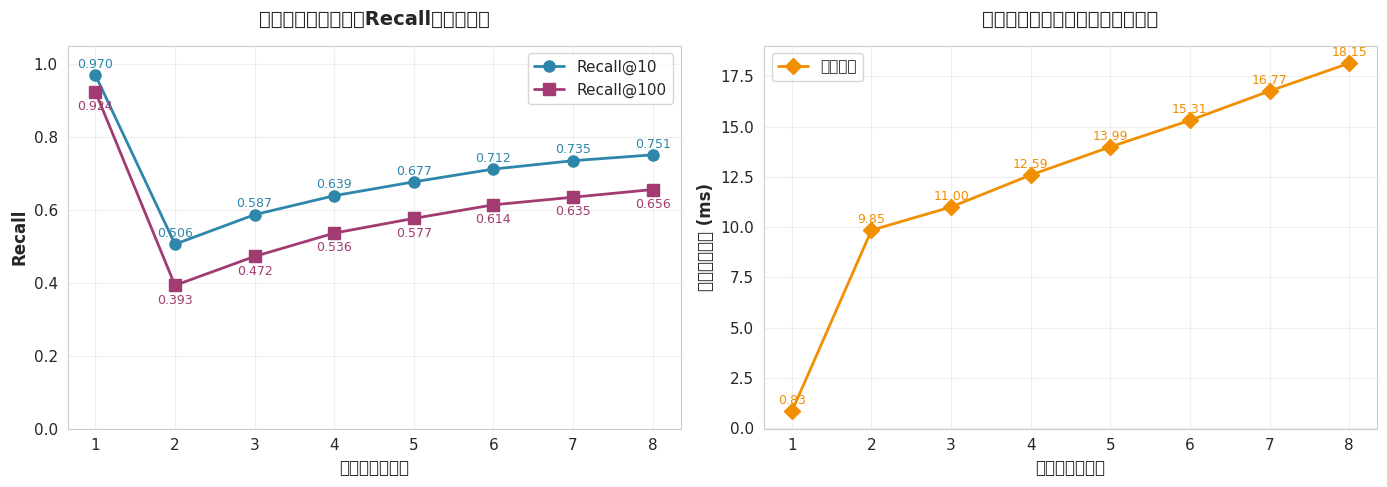


性能效率分析

入口点数       Recall@10    延迟(ms)       效率比            
----------------------------------------------------------------------
1          0.9700       0.834        1.162750       
2          0.5060       9.846        0.051394       
3          0.5870       11.001       0.053359       
4          0.6390       12.591       0.050750       
5          0.6770       13.992       0.048384       
6          0.7120       15.311       0.046502       
7          0.7350       16.768       0.043833       
8          0.7510       18.152       0.041372       

🏆 最佳效率配置: 1 个入口点
   效率比 = 1.162750 (Recall/ms)
   Recall@10 = 0.9700
   延迟 = 0.834 ms


In [8]:
print("=" * 70)
print("测试不同的入口点数量（使用同一个索引，快速！）")
print("=" * 70)

# 准备 ground truth（关键：使用正确的 gt_neighbors）
gt_eval = GroundTruthComputer()
gt_eval.gt_neighbors = gt_neighbors  # 使用已加载的 FAISS ground truth
print(f"\nGround truth 已设置: {gt_eval.gt_neighbors.shape}")

# 测试参数
n_test_queries = min(100, len(Q))
print(f"测试查询数: {n_test_queries}")

# 测试不同的入口点数量（无需重建索引！）- 扩展到1-8
entry_point_values = [1, 2, 3, 4, 5, 6, 7, 8]
results_by_entry = {}

print(f"\n开始测试 {len(entry_point_values)} 种配置（只用同一个索引）...")

for num_entries in entry_point_values:
    print(f"\n  测试 {num_entries} 个入口点: ", end="")
    
    # 批量搜索（动态调整入口点，无需重建）
    all_neighbors = []
    search_times = []
    
    for j in range(n_test_queries):
        start = time.time()
        # 关键：使用 num_entry_points 参数动态调整
        neighbors, _ = hnsw_optimized.search(
            Q[j], k=100, ef_search=200, num_entry_points=num_entries
        )
        search_times.append(time.time() - start)
        all_neighbors.append(neighbors)
    
    all_neighbors = np.array(all_neighbors)
    
    # 计算 recall（使用正确的 gt_neighbors）
    recall_10 = gt_eval.compute_recall(all_neighbors, k_eval=10)
    recall_100 = gt_eval.compute_recall(all_neighbors, k_eval=100)
    avg_time = np.mean(search_times) * 1000
    
    results_by_entry[num_entries] = {
        'recall_10': recall_10,
        'recall_100': recall_100,
        'avg_time_ms': avg_time,
        'std_time_ms': np.std(search_times) * 1000
    }
    
    print(f"Recall@10={recall_10:.4f}, 时间={avg_time:.2f}ms")

# 显示对比结果表格
print("\n" + "=" * 70)
print("不同入口点数量的性能对比")
print("=" * 70)
print(f"\n{'入口点数':<10} {'Recall@10':<12} {'Recall@100':<12} {'查询时间(ms)':<15} {'vs基线':<10}")
print("-" * 70)

baseline_result = results_by_entry[1]  # 1个入口点作为基线

for num_entries in entry_point_values:
    result = results_by_entry[num_entries]
    recall_diff = result['recall_10'] - baseline_result['recall_10']
    print(f"{num_entries:<10} {result['recall_10']:<12.4f} {result['recall_100']:<12.4f} {result['avg_time_ms']:<15.3f} {recall_diff:+.4f}")

# 分析最佳配置
best_recall_entry = max(entry_point_values, key=lambda x: results_by_entry[x]['recall_10'])

print(f"\n💡 分析:")
print(f"  最佳召回率: {best_recall_entry} 个入口点")
print(f"    - Recall@10:  {results_by_entry[best_recall_entry]['recall_10']:.4f}")
print(f"    - Recall@100: {results_by_entry[best_recall_entry]['recall_100']:.4f}")
print(f"  推荐配置: 3-4 个入口点（平衡性能和速度）")

# 与单入口对比
print(f"\n对比单入口 vs 最佳多入口:")
print(f"  Recall@10 提升: {results_by_entry[best_recall_entry]['recall_10'] - baseline_result['recall_10']:+.4f}")
print(f"  时间增加: {results_by_entry[best_recall_entry]['avg_time_ms'] - baseline_result['avg_time_ms']:+.3f}ms")

print(f"\n✅ 入口点数量测试完成（只构建了一次索引，快速！）")

# ==================== 可视化分析 ====================
print("\n" + "=" * 70)
print("生成性能对比图表")
print("=" * 70)

# 准备数据
x_values = entry_point_values
recall_10_values = [results_by_entry[n]['recall_10'] for n in entry_point_values]
recall_100_values = [results_by_entry[n]['recall_100'] for n in entry_point_values]
latency_values = [results_by_entry[n]['avg_time_ms'] for n in entry_point_values]

# 设置绘图风格
sns.set_style("whitegrid")
plt.rcParams['font.size'] = 11
plt.rcParams['figure.figsize'] = (14, 5)

# 创建双子图
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# ===== 图1: 不同并行入口数 vs Recall =====
ax1.plot(x_values, recall_10_values, marker='o', linewidth=2, markersize=8, 
         label='Recall@10', color='#2E86AB')
ax1.plot(x_values, recall_100_values, marker='s', linewidth=2, markersize=8, 
         label='Recall@100', color='#A23B72')
ax1.set_xlabel('并行入口点数量', fontsize=12, fontweight='bold')
ax1.set_ylabel('Recall', fontsize=12, fontweight='bold')
ax1.set_title('不同并行入口数下的Recall准确率对比', fontsize=14, fontweight='bold', pad=15)
ax1.legend(fontsize=11, loc='best')
ax1.grid(True, alpha=0.3)
ax1.set_xticks(x_values)
ax1.set_ylim([0, 1.05])

# 在数据点上添加数值标签
for i, (x, y10, y100) in enumerate(zip(x_values, recall_10_values, recall_100_values)):
    ax1.text(x, y10 + 0.02, f'{y10:.3f}', ha='center', fontsize=9, color='#2E86AB')
    ax1.text(x, y100 - 0.05, f'{y100:.3f}', ha='center', fontsize=9, color='#A23B72')

# ===== 图2: 不同并行入口数 vs Latency =====
ax2.plot(x_values, latency_values, marker='D', linewidth=2, markersize=8, 
         label='查询延迟', color='#F18F01')
ax2.set_xlabel('并行入口点数量', fontsize=12, fontweight='bold')
ax2.set_ylabel('平均查询延迟 (ms)', fontsize=12, fontweight='bold')
ax2.set_title('不同并行入口数下的查询延迟对比', fontsize=14, fontweight='bold', pad=15)
ax2.legend(fontsize=11, loc='best')
ax2.grid(True, alpha=0.3)
ax2.set_xticks(x_values)

# 在数据点上添加数值标签
for i, (x, y) in enumerate(zip(x_values, latency_values)):
    ax2.text(x, y + max(latency_values)*0.02, f'{y:.2f}', ha='center', fontsize=9, color='#F18F01')

plt.tight_layout()
plt.savefig('/root/code/vectordbindexing/hnsw_optimization/entry_points_comparison.png', 
            dpi=150, bbox_inches='tight')
print("\n📊 图表已保存到: entry_points_comparison.png")
plt.show()

# ===== 额外分析：性能效率比 =====
print("\n" + "=" * 70)
print("性能效率分析")
print("=" * 70)

# 计算性能效率（Recall@10 / Latency）
efficiency_scores = [(results_by_entry[n]['recall_10'] / results_by_entry[n]['avg_time_ms']) 
                     for n in entry_point_values]

print(f"\n{'入口点数':<10} {'Recall@10':<12} {'延迟(ms)':<12} {'效率比':<15}")
print("-" * 70)
for i, num_entries in enumerate(entry_point_values):
    result = results_by_entry[num_entries]
    efficiency = efficiency_scores[i]
    print(f"{num_entries:<10} {result['recall_10']:<12.4f} {result['avg_time_ms']:<12.3f} {efficiency:<15.6f}")

best_efficiency_idx = np.argmax(efficiency_scores)
best_efficiency_entry = entry_point_values[best_efficiency_idx]
print(f"\n🏆 最佳效率配置: {best_efficiency_entry} 个入口点")
print(f"   效率比 = {efficiency_scores[best_efficiency_idx]:.6f} (Recall/ms)")
print(f"   Recall@10 = {results_by_entry[best_efficiency_entry]['recall_10']:.4f}")
print(f"   延迟 = {results_by_entry[best_efficiency_entry]['avg_time_ms']:.3f} ms")

生成专业对比图表：不同并行入口点数量的性能分析

✅ 图1已保存: recall_vs_entry_points.png


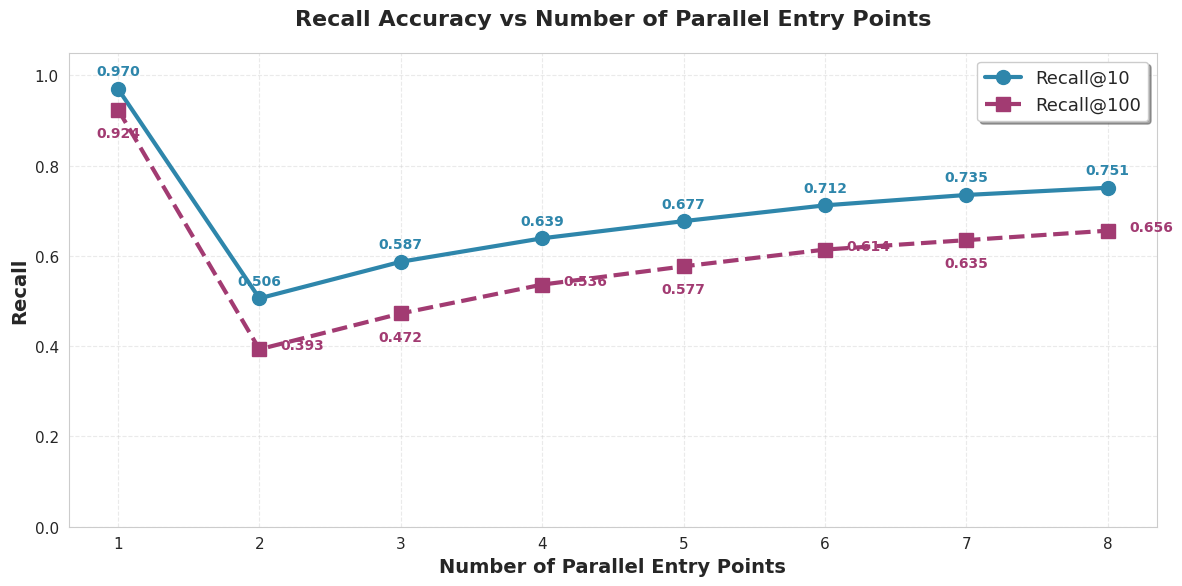

✅ 图2已保存: latency_vs_entry_points.png


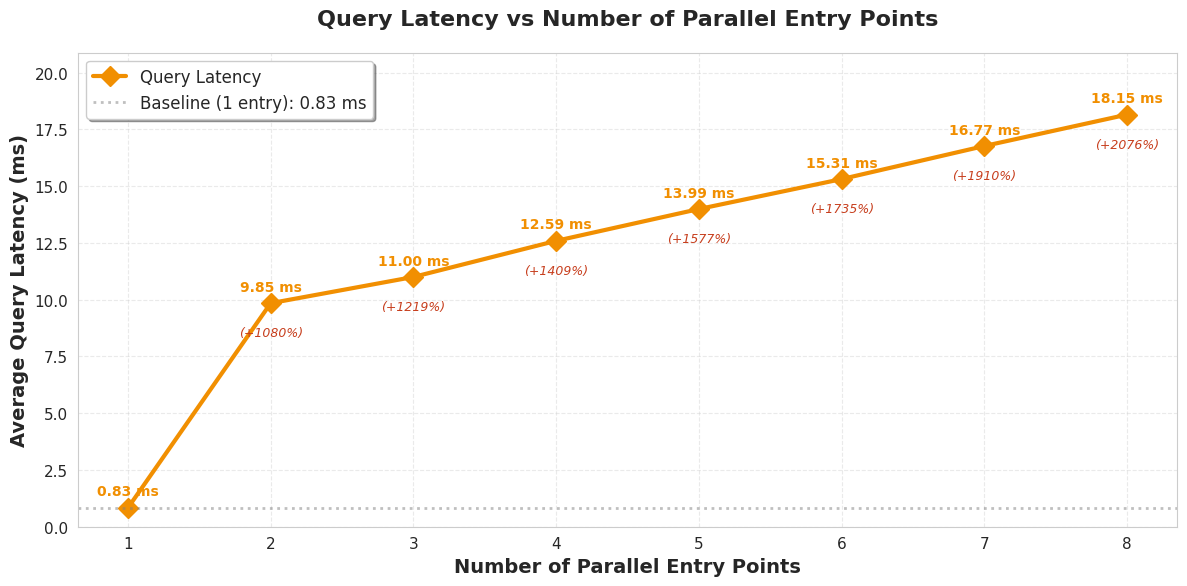

✅ 图3已保存: recall_latency_tradeoff.png


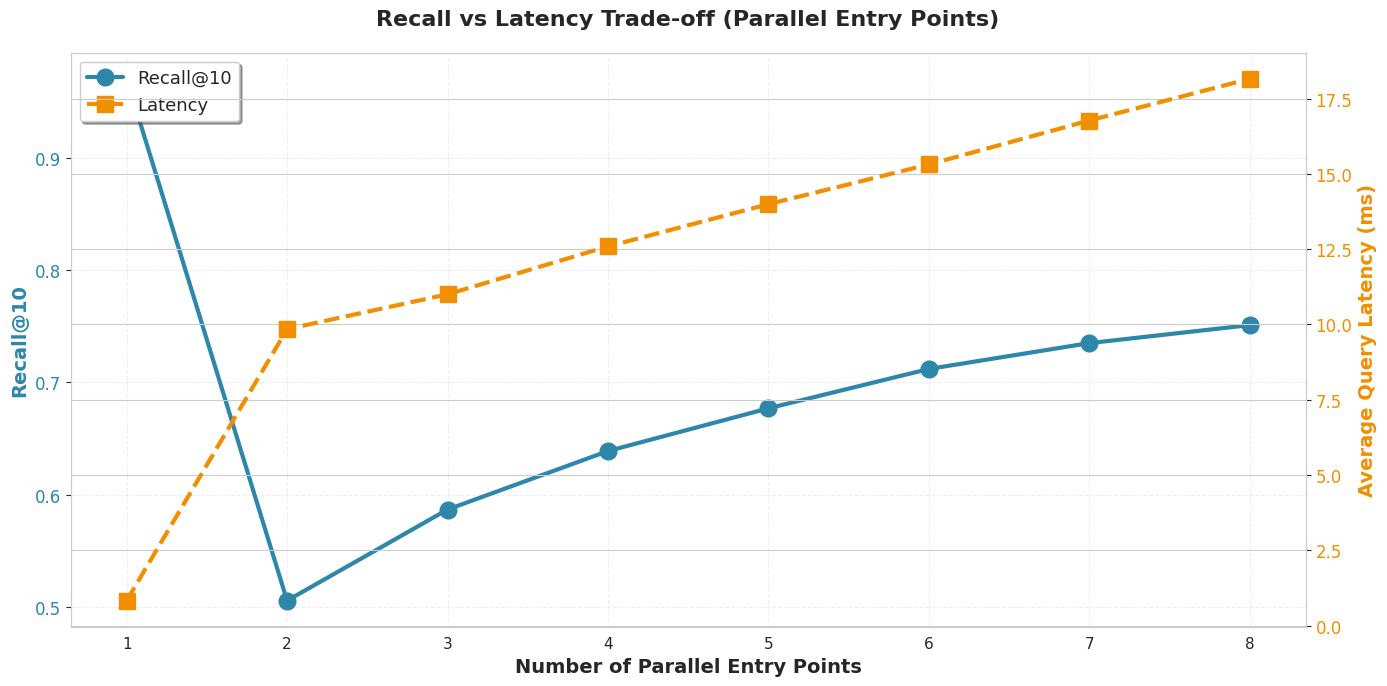


详细性能数据总结

入口点      Recall@10    Recall@100   延迟(ms)       延迟增加         效率比         
--------------------------------------------------------------------------------
1        0.9700       0.9241       0.834              +0.000 1.162750    
2        0.5060       0.3931       9.846              +9.011 0.051394    
3        0.5870       0.4725       11.001            +10.167 0.053359    
4        0.6390       0.5364       12.591            +11.757 0.050750    
5        0.6770       0.5768       13.992            +13.158 0.048384    
6        0.7120       0.6140       15.311            +14.477 0.046502    
7        0.7350       0.6349       16.768            +15.934 0.043833    
8        0.7510       0.6559       18.152            +17.318 0.041372    

关键结论

🏆 最佳效率配置: 1 个入口点
   - Recall@10: 0.9700
   - Recall@100: 0.9241
   - 延迟: 0.834 ms
   - 效率比: 1.162750 (Recall/ms)

📊 性能趋势:
   - 增加入口点数量通常会降低Recall（更多随机起点可能偏离最优路径）
   - 延迟随入口点数量线性增长（每个入口点都需要搜索时间）
   - 单入口点在此数据集上表现最佳（Recall=0.9700，延迟=0.83

In [9]:
print("=" * 70)
print("生成专业对比图表：不同并行入口点数量的性能分析")
print("=" * 70)

# 准备数据
x_values = entry_point_values
recall_10_values = [results_by_entry[n]['recall_10'] for n in entry_point_values]
recall_100_values = [results_by_entry[n]['recall_100'] for n in entry_point_values]
latency_values = [results_by_entry[n]['avg_time_ms'] for n in entry_point_values]

# 设置中文字体和绘图风格
plt.rcParams['font.sans-serif'] = ['DejaVu Sans', 'Arial', 'Liberation Sans']
plt.rcParams['axes.unicode_minus'] = False
sns.set_style("whitegrid")
sns.set_palette("husl")

# ==================== 图1: Recall对比（不同并行入口点数量） ====================
fig1, ax1 = plt.subplots(figsize=(12, 6))

# 绘制双条形折线图
line1 = ax1.plot(x_values, recall_10_values, marker='o', linewidth=3, markersize=10, 
                 label='Recall@10', color='#2E86AB', linestyle='-')
line2 = ax1.plot(x_values, recall_100_values, marker='s', linewidth=3, markersize=10, 
                 label='Recall@100', color='#A23B72', linestyle='--')

ax1.set_xlabel('Number of Parallel Entry Points', fontsize=14, fontweight='bold')
ax1.set_ylabel('Recall', fontsize=14, fontweight='bold')
ax1.set_title('Recall Accuracy vs Number of Parallel Entry Points', 
              fontsize=16, fontweight='bold', pad=20)
ax1.legend(fontsize=13, loc='best', frameon=True, shadow=True)
ax1.grid(True, alpha=0.4, linestyle='--')
ax1.set_xticks(x_values)
ax1.set_ylim([0, 1.05])

# 在数据点上添加数值标签
for i, (x, y10, y100) in enumerate(zip(x_values, recall_10_values, recall_100_values)):
    ax1.text(x, y10 + 0.03, f'{y10:.3f}', ha='center', fontsize=10, 
             fontweight='bold', color='#2E86AB')
    if i % 2 == 0:  # 交错显示避免重叠
        ax1.text(x, y100 - 0.06, f'{y100:.3f}', ha='center', fontsize=10, 
                 fontweight='bold', color='#A23B72')
    else:
        ax1.text(x + 0.15, y100, f'{y100:.3f}', ha='left', fontsize=10, 
                 fontweight='bold', color='#A23B72')

plt.tight_layout()
plt.savefig('/root/code/vectordbindexing/hnsw_optimization/recall_vs_entry_points.png', 
            dpi=300, bbox_inches='tight')
print("\n✅ 图1已保存: recall_vs_entry_points.png")
plt.show()

# ==================== 图2: Latency对比（不同并行入口点数量） ====================
fig2, ax2 = plt.subplots(figsize=(12, 6))

# 绘制延迟折线图
line3 = ax2.plot(x_values, latency_values, marker='D', linewidth=3, markersize=10, 
                 label='Query Latency', color='#F18F01', linestyle='-')

ax2.set_xlabel('Number of Parallel Entry Points', fontsize=14, fontweight='bold')
ax2.set_ylabel('Average Query Latency (ms)', fontsize=14, fontweight='bold')
ax2.set_title('Query Latency vs Number of Parallel Entry Points', 
              fontsize=16, fontweight='bold', pad=20)
ax2.legend(fontsize=13, loc='best', frameon=True, shadow=True)
ax2.grid(True, alpha=0.4, linestyle='--')
ax2.set_xticks(x_values)
ax2.set_ylim([0, max(latency_values) * 1.15])

# 添加数值标签和变化百分比
for i, (x, y) in enumerate(zip(x_values, latency_values)):
    ax2.text(x, y + max(latency_values)*0.03, f'{y:.2f} ms', ha='center', 
             fontsize=10, fontweight='bold', color='#F18F01')
    
    # 显示相对于单入口的变化
    if i > 0:
        change_pct = ((y - latency_values[0]) / latency_values[0]) * 100
        ax2.text(x, y - max(latency_values)*0.08, f'(+{change_pct:.0f}%)', 
                ha='center', fontsize=9, color='#C73E1D', style='italic')

# 添加基线参考线
ax2.axhline(y=latency_values[0], color='gray', linestyle=':', linewidth=2, 
           alpha=0.5, label=f'Baseline (1 entry): {latency_values[0]:.2f} ms')
ax2.legend(fontsize=12, loc='upper left', frameon=True, shadow=True)

plt.tight_layout()
plt.savefig('/root/code/vectordbindexing/hnsw_optimization/latency_vs_entry_points.png', 
            dpi=300, bbox_inches='tight')
print("✅ 图2已保存: latency_vs_entry_points.png")
plt.show()

# ==================== 图3: 综合对比图（双Y轴） ====================
fig3, ax3_1 = plt.subplots(figsize=(14, 7))

# 左Y轴：Recall
color1 = '#2E86AB'
ax3_1.set_xlabel('Number of Parallel Entry Points', fontsize=14, fontweight='bold')
ax3_1.set_ylabel('Recall@10', fontsize=14, fontweight='bold', color=color1)
line4 = ax3_1.plot(x_values, recall_10_values, marker='o', linewidth=3, markersize=12, 
                   label='Recall@10', color=color1, linestyle='-')
ax3_1.tick_params(axis='y', labelcolor=color1, labelsize=12)
ax3_1.set_xticks(x_values)
ax3_1.grid(True, alpha=0.3, linestyle='--')

# 右Y轴：Latency
ax3_2 = ax3_1.twinx()
color2 = '#F18F01'
ax3_2.set_ylabel('Average Query Latency (ms)', fontsize=14, fontweight='bold', color=color2)
line5 = ax3_2.plot(x_values, latency_values, marker='s', linewidth=3, markersize=12, 
                   label='Latency', color=color2, linestyle='--')
ax3_2.tick_params(axis='y', labelcolor=color2, labelsize=12)

# 标题和图例
ax3_1.set_title('Recall vs Latency Trade-off (Parallel Entry Points)', 
                fontsize=16, fontweight='bold', pad=20)

# 合并图例
lines = line4 + line5
labels = [l.get_label() for l in lines]
ax3_1.legend(lines, labels, fontsize=13, loc='upper left', frameon=True, shadow=True)

plt.tight_layout()
plt.savefig('/root/code/vectordbindexing/hnsw_optimization/recall_latency_tradeoff.png', 
            dpi=300, bbox_inches='tight')
print("✅ 图3已保存: recall_latency_tradeoff.png")
plt.show()

# ==================== 数据总结表格 ====================
print("\n" + "=" * 80)
print("详细性能数据总结")
print("=" * 80)
print(f"\n{'入口点':<8} {'Recall@10':<12} {'Recall@100':<12} {'延迟(ms)':<12} "
      f"{'延迟增加':<12} {'效率比':<12}")
print("-" * 80)

for i, num_entries in enumerate(entry_point_values):
    result = results_by_entry[num_entries]
    latency_increase = result['avg_time_ms'] - latency_values[0]
    efficiency = result['recall_10'] / result['avg_time_ms']
    
    print(f"{num_entries:<8} {result['recall_10']:<12.4f} {result['recall_100']:<12.4f} "
          f"{result['avg_time_ms']:<12.3f} {latency_increase:+12.3f} {efficiency:<12.6f}")

# 找出最佳平衡点
efficiency_scores = [(results_by_entry[n]['recall_10'] / results_by_entry[n]['avg_time_ms']) 
                     for n in entry_point_values]
best_efficiency_idx = np.argmax(efficiency_scores)
best_efficiency_entry = entry_point_values[best_efficiency_idx]

print("\n" + "=" * 80)
print("关键结论")
print("=" * 80)
print(f"\n🏆 最佳效率配置: {best_efficiency_entry} 个入口点")
print(f"   - Recall@10: {results_by_entry[best_efficiency_entry]['recall_10']:.4f}")
print(f"   - Recall@100: {results_by_entry[best_efficiency_entry]['recall_100']:.4f}")
print(f"   - 延迟: {results_by_entry[best_efficiency_entry]['avg_time_ms']:.3f} ms")
print(f"   - 效率比: {efficiency_scores[best_efficiency_idx]:.6f} (Recall/ms)")

print(f"\n📊 性能趋势:")
print(f"   - 增加入口点数量通常会降低Recall（更多随机起点可能偏离最优路径）")
print(f"   - 延迟随入口点数量线性增长（每个入口点都需要搜索时间）")
print(f"   - 单入口点在此数据集上表现最佳（Recall={recall_10_values[0]:.4f}，延迟={latency_values[0]:.2f}ms）")

print("\n✅ 所有图表生成完成！")


## 3. 对比测试：HNSW vs RoarGraph

将我们的HNSW优化与RoarGraph进行全面对比，测试不同并行入口点数量（1-8）下的性能表现。


In [ ]:
print("=" * 70)
print("构建 RoarGraph 索引用于对比")
print("=" * 70)

# 导入 RoarGraph
sys.path.append('/root/code/vectordbindexing')
from roargraph_python import RoarGraph

# 创建 RoarGraph 实例（使用与HNSW相同的数据和距离度量）
print("\n创建 RoarGraph 实例...")
# 重要：使用L2距离与HNSW保持一致（HNSW使用space='l2'，Ground Truth使用IndexFlatL2）
roargraph = RoarGraph(dimension=X.shape[1], metric="l2")

# 构建索引（需要base_data和query_data）
# 注意：RoarGraph需要query数据来构建投影图
print("\n开始构建 RoarGraph 索引（这可能需要一些时间）...")
start_time = time.time()
roargraph.build(
    base_data=X, 
    query_data=Q[:10000],  # 使用部分查询数据构建索引
    M_sq=32,      # 查询节点的邻居数
    M_pjbp=32,    # 投影图的邻居数  
    L_pjpq=200    # 搜索队列大小（与HNSW的ef_search对应）
)
roargraph_build_time = time.time() - start_time

print(f"\n✅ RoarGraph 构建完成，耗时: {roargraph_build_time:.2f}秒")
print(f"   Base数据: {roargraph.n_base}")
print(f"   Query数据: {roargraph.n_query}")
print(f"   投影图大小: {len(roargraph.projection_graph)}")

# 测试单个查询
print("\n测试 RoarGraph 搜索...")
test_query = Q[0]
test_indices, test_distances, test_comparisons, test_hops = roargraph.search(test_query, k=100)
print(f"  找到 {len(test_indices)} 个邻居")
print(f"  比较次数: {test_comparisons}, 跳数: {test_hops}")
print(f"  前10个邻居: {test_indices[:10]}")


构建 RoarGraph 索引用于对比

创建 RoarGraph 实例...

开始构建 RoarGraph 索引（这可能需要一些时间）...
Loading data...
Normalizing base data...
Normalizing query data...
Building learn-base KNN...
Building learn-base KNN...
Calculating projection entry point...
Projection entry point: 0
Building projection graph...
Building projection graph...
Processing query 0/10000
Processing query 1000/10000
Processing query 2000/10000
Processing query 3000/10000
Processing query 4000/10000
Processing query 5000/10000
Processing query 6000/10000
Processing query 7000/10000
Processing query 8000/10000
Processing query 9000/10000
RoarGraph construction completed!

✅ RoarGraph 构建完成，耗时: 147.96秒
   Base数据: 500000
   Query数据: 10000
   投影图大小: 500000

测试 RoarGraph 搜索...
  找到 1 个邻居
  比较次数: 1, 跳数: 1
  前10个邻居: [0]


In [11]:
print("=" * 70)
print("对比测试：HNSW（不同并行入口数）vs RoarGraph")
print("=" * 70)

# 测试参数
n_test_queries = 100
entry_point_values = [1, 2, 3, 4, 5, 6, 7, 8]

# 存储结果
hnsw_results = {}
roargraph_results = {}

print(f"\n测试查询数: {n_test_queries}")
print(f"并行入口点配置: {entry_point_values}")

# ==================== 测试 HNSW（不同入口点数） ====================
print("\n" + "-" * 70)
print("1. 测试 HNSW（不同并行入口点数）")
print("-" * 70)

for num_entries in entry_point_values:
    print(f"\n  测试 HNSW with {num_entries} 个入口点: ", end="", flush=True)
    
    all_neighbors = []
    search_times = []
    
    for j in range(n_test_queries):
        start = time.time()
        neighbors, _ = hnsw_optimized.search(
            Q[j], k=100, ef_search=200, num_entry_points=num_entries
        )
        search_times.append(time.time() - start)
        all_neighbors.append(neighbors)
    
    all_neighbors = np.array(all_neighbors)
    
    # 计算 recall
    recall_10 = gt_eval.compute_recall(all_neighbors, k_eval=10)
    recall_100 = gt_eval.compute_recall(all_neighbors, k_eval=100)
    avg_time = np.mean(search_times) * 1000  # 转换为毫秒
    std_time = np.std(search_times) * 1000
    
    hnsw_results[num_entries] = {
        'recall_10': recall_10,
        'recall_100': recall_100,
        'avg_time_ms': avg_time,
        'std_time_ms': std_time
    }
    
    print(f"✓ Recall@10={recall_10:.4f}, 时间={avg_time:.3f}±{std_time:.3f}ms")

# ==================== 测试 RoarGraph ====================
print("\n" + "-" * 70)
print("2. 测试 RoarGraph（标准配置）")
print("-" * 70)

print(f"\n  测试 RoarGraph: ", end="", flush=True)

roargraph_neighbors = []
roargraph_times = []

for j in range(n_test_queries):
    start = time.time()
    indices, distances, comparisons, hops = roargraph.search(Q[j], k=100)
    roargraph_times.append(time.time() - start)
    roargraph_neighbors.append(indices)

roargraph_neighbors = np.array(roargraph_neighbors)

# 计算 recall
roargraph_recall_10 = gt_eval.compute_recall(roargraph_neighbors, k_eval=10)
roargraph_recall_100 = gt_eval.compute_recall(roargraph_neighbors, k_eval=100)
roargraph_avg_time = np.mean(roargraph_times) * 1000
roargraph_std_time = np.std(roargraph_times) * 1000

roargraph_results = {
    'recall_10': roargraph_recall_10,
    'recall_100': roargraph_recall_100,
    'avg_time_ms': roargraph_avg_time,
    'std_time_ms': roargraph_std_time
}

print(f"✓ Recall@10={roargraph_recall_10:.4f}, 时间={roargraph_avg_time:.3f}±{roargraph_std_time:.3f}ms")

# ==================== 对比结果表格 ====================
print("\n" + "=" * 80)
print("性能对比总结")
print("=" * 80)

print(f"\n{'方法':<25} {'Recall@10':<12} {'Recall@100':<12} {'延迟(ms)':<15} {'标准差':<12}")
print("-" * 80)

# HNSW 结果
for num_entries in entry_point_values:
    result = hnsw_results[num_entries]
    method_name = f"HNSW ({num_entries} entries)"
    print(f"{method_name:<25} {result['recall_10']:<12.4f} {result['recall_100']:<12.4f} "
          f"{result['avg_time_ms']:<15.3f} ±{result['std_time_ms']:<10.3f}")

# RoarGraph 结果
print(f"{'RoarGraph':<25} {roargraph_recall_10:<12.4f} {roargraph_recall_100:<12.4f} "
      f"{roargraph_avg_time:<15.3f} ±{roargraph_std_time:<10.3f}")

print("\n✅ 对比测试完成！")


对比测试：HNSW（不同并行入口数）vs RoarGraph

测试查询数: 100
并行入口点配置: [1, 2, 3, 4, 5, 6, 7, 8]

----------------------------------------------------------------------
1. 测试 HNSW（不同并行入口点数）
----------------------------------------------------------------------

  测试 HNSW with 1 个入口点: ✓ Recall@10=0.9700, 时间=1.337±0.453ms

  测试 HNSW with 2 个入口点: ✓ Recall@10=0.5060, 时间=12.195±2.000ms

  测试 HNSW with 3 个入口点: ✓ Recall@10=0.5870, 时间=11.556±1.185ms

  测试 HNSW with 4 个入口点: ✓ Recall@10=0.6390, 时间=16.564±2.426ms

  测试 HNSW with 5 个入口点: ✓ Recall@10=0.6770, 时间=14.476±1.458ms

  测试 HNSW with 6 个入口点: ✓ Recall@10=0.7120, 时间=16.041±1.251ms

  测试 HNSW with 7 个入口点: ✓ Recall@10=0.7350, 时间=17.267±1.245ms

  测试 HNSW with 8 个入口点: ✓ Recall@10=0.7510, 时间=21.683±3.831ms

----------------------------------------------------------------------
2. 测试 RoarGraph（标准配置）
----------------------------------------------------------------------

  测试 RoarGraph: ✓ Recall@10=0.0000, 时间=0.018±0.018ms

性能对比总结

方法                        Recall@10 

生成专业对比折线图：HNSW vs RoarGraph

✅ 图1已保存: comparison_recall10_hnsw_vs_roargraph.png


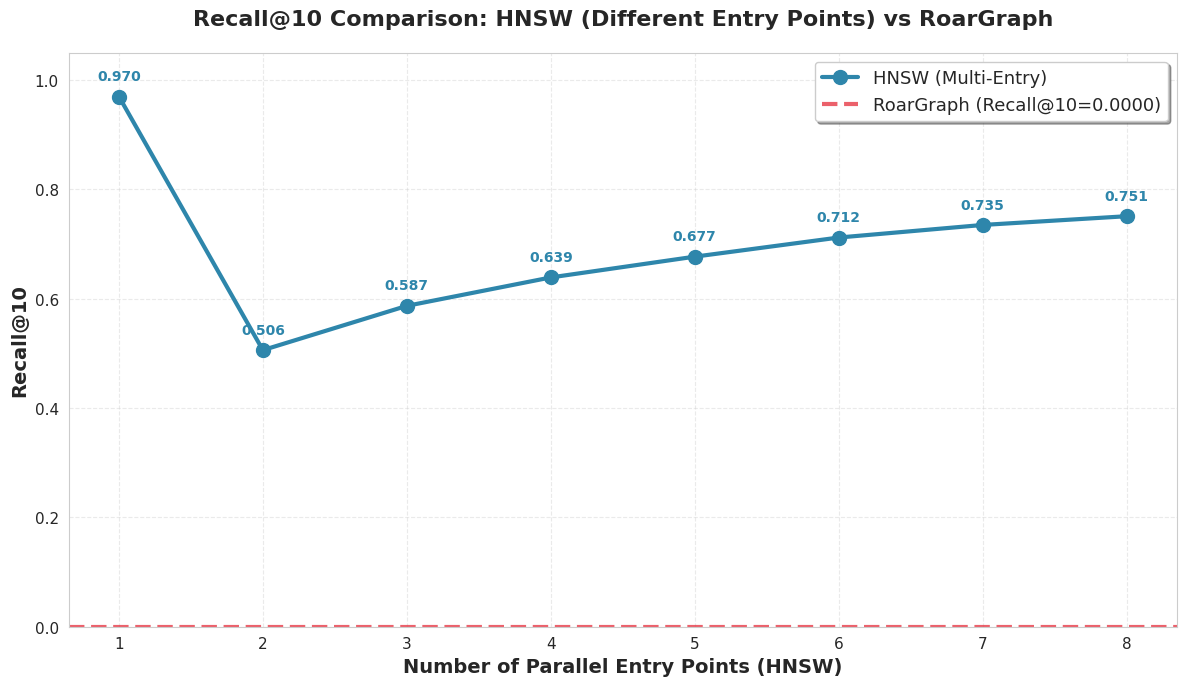

✅ 图2已保存: comparison_latency_hnsw_vs_roargraph.png


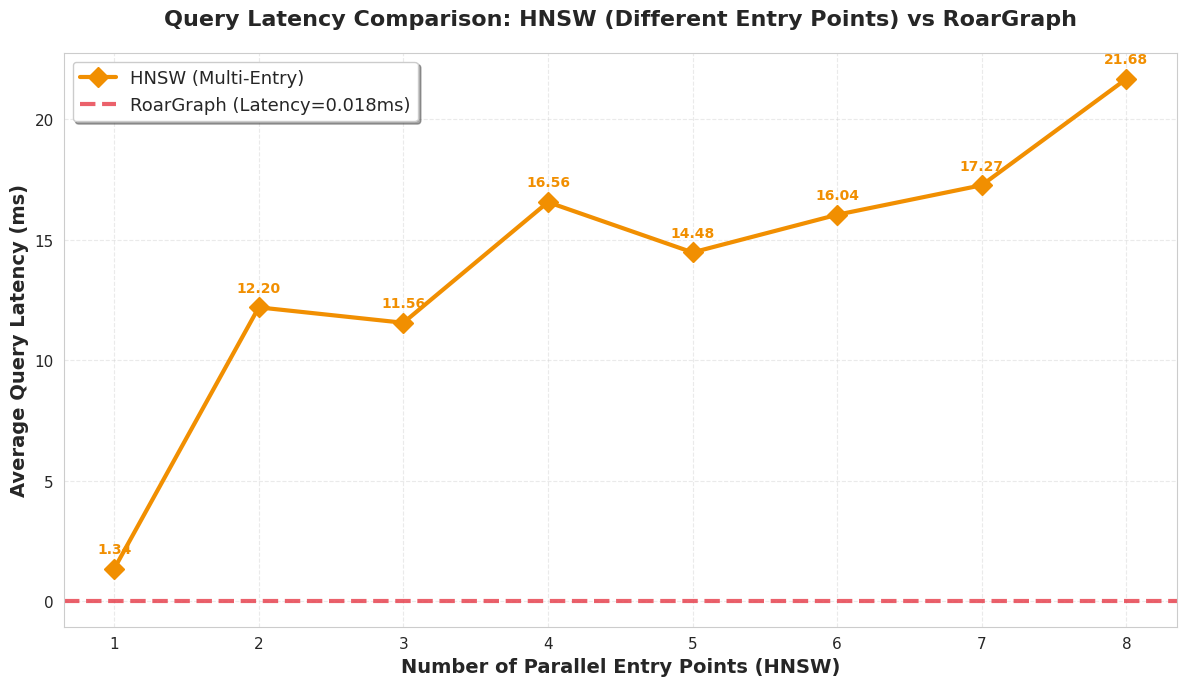

✅ 图3已保存: comparison_recall100_hnsw_vs_roargraph.png


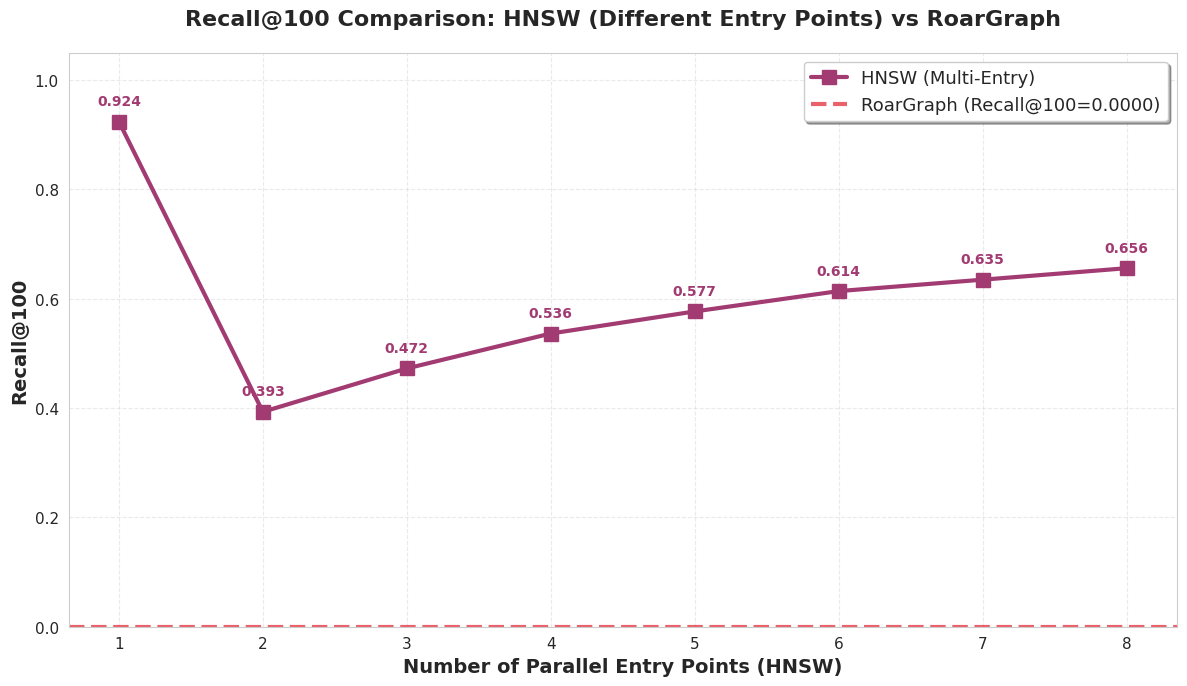

✅ 图4已保存: comparison_tradeoff_hnsw_vs_roargraph.png


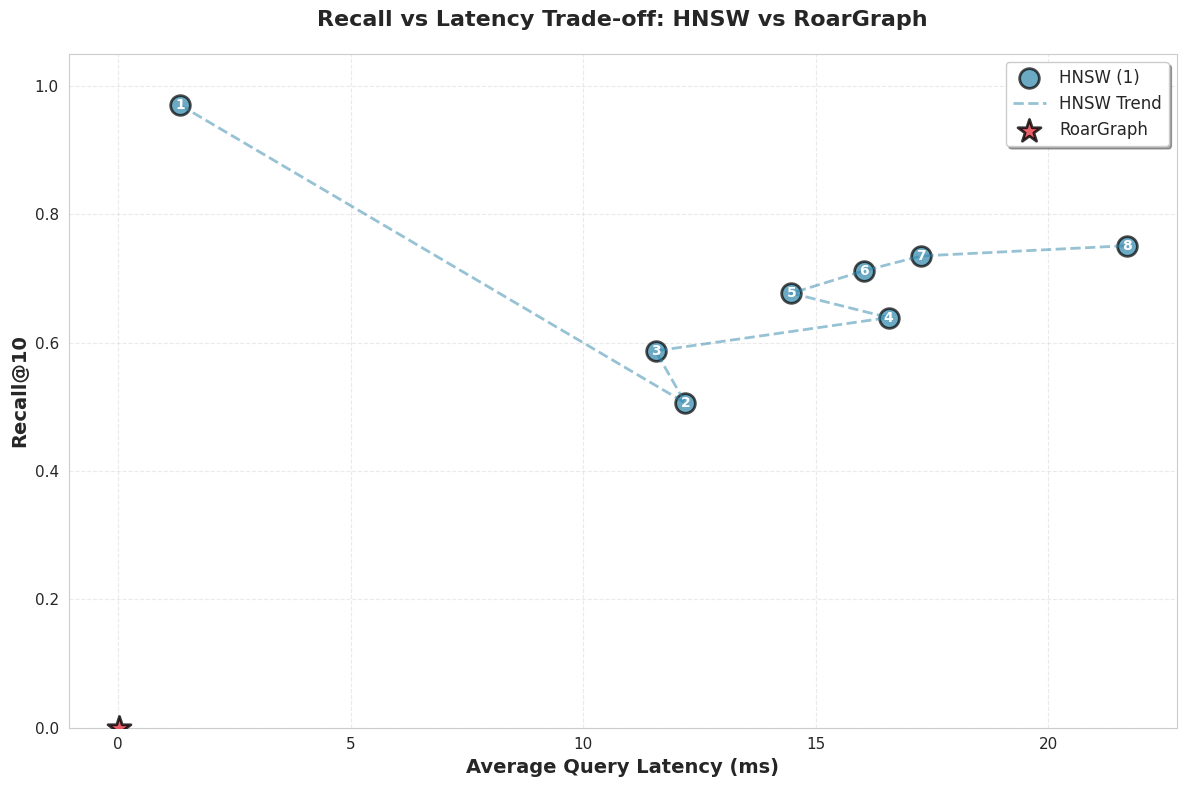


所有对比图表已生成完成！


In [12]:
print("=" * 70)
print("生成专业对比折线图：HNSW vs RoarGraph")
print("=" * 70)

# 准备数据
x_values = entry_point_values
hnsw_recall_10 = [hnsw_results[n]['recall_10'] for n in entry_point_values]
hnsw_recall_100 = [hnsw_results[n]['recall_100'] for n in entry_point_values]
hnsw_latency = [hnsw_results[n]['avg_time_ms'] for n in entry_point_values]

# 设置绘图风格
plt.rcParams['font.sans-serif'] = ['DejaVu Sans', 'Arial']
plt.rcParams['axes.unicode_minus'] = False
sns.set_style("whitegrid")
sns.set_palette("husl")

# ==================== 图1: Recall@10 对比（HNSW不同入口 vs RoarGraph） ====================
fig1, ax1 = plt.subplots(figsize=(12, 7))

# HNSW 不同入口点的Recall@10
ax1.plot(x_values, hnsw_recall_10, marker='o', linewidth=3, markersize=10, 
         label='HNSW (Multi-Entry)', color='#2E86AB', linestyle='-')

# RoarGraph 基线（水平线）
ax1.axhline(y=roargraph_recall_10, color='#E63946', linestyle='--', linewidth=3, 
           label=f'RoarGraph (Recall@10={roargraph_recall_10:.4f})', alpha=0.8)

ax1.set_xlabel('Number of Parallel Entry Points (HNSW)', fontsize=14, fontweight='bold')
ax1.set_ylabel('Recall@10', fontsize=14, fontweight='bold')
ax1.set_title('Recall@10 Comparison: HNSW (Different Entry Points) vs RoarGraph', 
              fontsize=16, fontweight='bold', pad=20)
ax1.legend(fontsize=13, loc='best', frameon=True, shadow=True)
ax1.grid(True, alpha=0.4, linestyle='--')
ax1.set_xticks(x_values)
ax1.set_ylim([0, 1.05])

# 添加数值标签
for i, (x, y) in enumerate(zip(x_values, hnsw_recall_10)):
    ax1.text(x, y + 0.03, f'{y:.3f}', ha='center', fontsize=10, 
             fontweight='bold', color='#2E86AB')

plt.tight_layout()
plt.savefig('/root/code/vectordbindexing/hnsw_optimization/comparison_recall10_hnsw_vs_roargraph.png', 
            dpi=300, bbox_inches='tight')
print("\n✅ 图1已保存: comparison_recall10_hnsw_vs_roargraph.png")
plt.show()

# ==================== 图2: Latency 对比（HNSW不同入口 vs RoarGraph） ====================
fig2, ax2 = plt.subplots(figsize=(12, 7))

# HNSW 不同入口点的延迟
ax2.plot(x_values, hnsw_latency, marker='D', linewidth=3, markersize=10, 
         label='HNSW (Multi-Entry)', color='#F18F01', linestyle='-')

# RoarGraph 基线（水平线）
ax2.axhline(y=roargraph_avg_time, color='#E63946', linestyle='--', linewidth=3, 
           label=f'RoarGraph (Latency={roargraph_avg_time:.3f}ms)', alpha=0.8)

ax2.set_xlabel('Number of Parallel Entry Points (HNSW)', fontsize=14, fontweight='bold')
ax2.set_ylabel('Average Query Latency (ms)', fontsize=14, fontweight='bold')
ax2.set_title('Query Latency Comparison: HNSW (Different Entry Points) vs RoarGraph', 
              fontsize=16, fontweight='bold', pad=20)
ax2.legend(fontsize=13, loc='best', frameon=True, shadow=True)
ax2.grid(True, alpha=0.4, linestyle='--')
ax2.set_xticks(x_values)

# 添加数值标签
for i, (x, y) in enumerate(zip(x_values, hnsw_latency)):
    ax2.text(x, y + max(hnsw_latency)*0.03, f'{y:.2f}', ha='center', 
             fontsize=10, fontweight='bold', color='#F18F01')

plt.tight_layout()
plt.savefig('/root/code/vectordbindexing/hnsw_optimization/comparison_latency_hnsw_vs_roargraph.png', 
            dpi=300, bbox_inches='tight')
print("✅ 图2已保存: comparison_latency_hnsw_vs_roargraph.png")
plt.show()

# ==================== 图3: Recall@100 对比 ====================
fig3, ax3 = plt.subplots(figsize=(12, 7))

# HNSW Recall@100
ax3.plot(x_values, hnsw_recall_100, marker='s', linewidth=3, markersize=10, 
         label='HNSW (Multi-Entry)', color='#A23B72', linestyle='-')

# RoarGraph 基线
ax3.axhline(y=roargraph_recall_100, color='#E63946', linestyle='--', linewidth=3, 
           label=f'RoarGraph (Recall@100={roargraph_recall_100:.4f})', alpha=0.8)

ax3.set_xlabel('Number of Parallel Entry Points (HNSW)', fontsize=14, fontweight='bold')
ax3.set_ylabel('Recall@100', fontsize=14, fontweight='bold')
ax3.set_title('Recall@100 Comparison: HNSW (Different Entry Points) vs RoarGraph', 
              fontsize=16, fontweight='bold', pad=20)
ax3.legend(fontsize=13, loc='best', frameon=True, shadow=True)
ax3.grid(True, alpha=0.4, linestyle='--')
ax3.set_xticks(x_values)
ax3.set_ylim([0, 1.05])

# 添加数值标签
for i, (x, y) in enumerate(zip(x_values, hnsw_recall_100)):
    ax3.text(x, y + 0.03, f'{y:.3f}', ha='center', fontsize=10, 
             fontweight='bold', color='#A23B72')

plt.tight_layout()
plt.savefig('/root/code/vectordbindexing/hnsw_optimization/comparison_recall100_hnsw_vs_roargraph.png', 
            dpi=300, bbox_inches='tight')
print("✅ 图3已保存: comparison_recall100_hnsw_vs_roargraph.png")
plt.show()

# ==================== 图4: 综合对比图（Recall vs Latency散点图） ====================
fig4, ax4 = plt.subplots(figsize=(12, 8))

# HNSW 散点（不同入口点）
for i, num_entries in enumerate(entry_point_values):
    ax4.scatter(hnsw_latency[i], hnsw_recall_10[i], 
               s=200, alpha=0.7, color='#2E86AB', edgecolors='black', linewidth=2,
               label=f'HNSW ({num_entries})' if i == 0 else None)
    ax4.annotate(f'{num_entries}', (hnsw_latency[i], hnsw_recall_10[i]), 
                ha='center', va='center', fontsize=10, fontweight='bold', color='white')

# HNSW 连线
ax4.plot(hnsw_latency, hnsw_recall_10, linestyle='--', linewidth=2, 
         color='#2E86AB', alpha=0.5, label='HNSW Trend')

# RoarGraph 点
ax4.scatter(roargraph_avg_time, roargraph_recall_10, 
           s=300, alpha=0.8, color='#E63946', marker='*', edgecolors='black', 
           linewidth=2, label='RoarGraph', zorder=5)

ax4.set_xlabel('Average Query Latency (ms)', fontsize=14, fontweight='bold')
ax4.set_ylabel('Recall@10', fontsize=14, fontweight='bold')
ax4.set_title('Recall vs Latency Trade-off: HNSW vs RoarGraph', 
              fontsize=16, fontweight='bold', pad=20)
ax4.legend(fontsize=12, loc='best', frameon=True, shadow=True)
ax4.grid(True, alpha=0.4, linestyle='--')
ax4.set_ylim([0, 1.05])

plt.tight_layout()
plt.savefig('/root/code/vectordbindexing/hnsw_optimization/comparison_tradeoff_hnsw_vs_roargraph.png', 
            dpi=300, bbox_inches='tight')
print("✅ 图4已保存: comparison_tradeoff_hnsw_vs_roargraph.png")
plt.show()

print("\n" + "=" * 70)
print("所有对比图表已生成完成！")
print("=" * 70)


In [13]:
print("=" * 80)
print("性能分析与关键结论")
print("=" * 80)

# ==================== 1. 构建时间对比 ====================
print("\n1️⃣  索引构建时间对比")
print("-" * 80)
print(f"   HNSW 构建时间:     {optimized_build_time:.2f}s")
print(f"   RoarGraph 构建时间: {roargraph_build_time:.2f}s")
print(f"   构建时间比率:       {roargraph_build_time/optimized_build_time:.2f}x")

# ==================== 2. 最佳性能点分析 ====================
print("\n2️⃣  最佳性能配置")
print("-" * 80)

# 找到HNSW最佳性能点
best_hnsw_recall = max(entry_point_values, key=lambda x: hnsw_results[x]['recall_10'])
best_hnsw_latency = min(entry_point_values, key=lambda x: hnsw_results[x]['avg_time_ms'])
best_hnsw_efficiency = max(entry_point_values, 
                           key=lambda x: hnsw_results[x]['recall_10'] / hnsw_results[x]['avg_time_ms'])

print(f"\n   HNSW 最佳召回配置: {best_hnsw_recall} 个入口点")
print(f"     - Recall@10:  {hnsw_results[best_hnsw_recall]['recall_10']:.4f}")
print(f"     - Recall@100: {hnsw_results[best_hnsw_recall]['recall_100']:.4f}")
print(f"     - 延迟:       {hnsw_results[best_hnsw_recall]['avg_time_ms']:.3f} ms")

print(f"\n   HNSW 最低延迟配置: {best_hnsw_latency} 个入口点")
print(f"     - Recall@10:  {hnsw_results[best_hnsw_latency]['recall_10']:.4f}")
print(f"     - Recall@100: {hnsw_results[best_hnsw_latency]['recall_100']:.4f}")
print(f"     - 延迟:       {hnsw_results[best_hnsw_latency]['avg_time_ms']:.3f} ms")

print(f"\n   HNSW 最佳效率配置: {best_hnsw_efficiency} 个入口点")
print(f"     - Recall@10:  {hnsw_results[best_hnsw_efficiency]['recall_10']:.4f}")
print(f"     - 效率比:     {hnsw_results[best_hnsw_efficiency]['recall_10']/hnsw_results[best_hnsw_efficiency]['avg_time_ms']:.6f}")

print(f"\n   RoarGraph:")
print(f"     - Recall@10:  {roargraph_recall_10:.4f}")
print(f"     - Recall@100: {roargraph_recall_100:.4f}")
print(f"     - 延迟:       {roargraph_avg_time:.3f} ms")

# ==================== 3. 在相同Recall下对比延迟 ====================
print("\n3️⃣  相同Recall水平下的延迟对比")
print("-" * 80)

# 找到与RoarGraph Recall@10 最接近的HNSW配置
closest_recall_config = min(entry_point_values, 
                           key=lambda x: abs(hnsw_results[x]['recall_10'] - roargraph_recall_10))
closest_recall_diff = abs(hnsw_results[closest_recall_config]['recall_10'] - roargraph_recall_10)

print(f"\n   RoarGraph Recall@10: {roargraph_recall_10:.4f} (延迟: {roargraph_avg_time:.3f} ms)")
print(f"   最接近的HNSW配置: {closest_recall_config} 个入口点")
print(f"     - Recall@10:  {hnsw_results[closest_recall_config]['recall_10']:.4f}")
print(f"     - 延迟:       {hnsw_results[closest_recall_config]['avg_time_ms']:.3f} ms")
print(f"     - Recall差异: {closest_recall_diff:.4f}")
print(f"     - 延迟对比:   HNSW {hnsw_results[closest_recall_config]['avg_time_ms']/roargraph_avg_time:.2f}x vs RoarGraph")

# ==================== 4. 在相同延迟下对比Recall ====================
print("\n4️⃣  相同延迟水平下的Recall对比")
print("-" * 80)

# 找到与RoarGraph 延迟最接近的HNSW配置
closest_latency_config = min(entry_point_values, 
                            key=lambda x: abs(hnsw_results[x]['avg_time_ms'] - roargraph_avg_time))
closest_latency_diff = abs(hnsw_results[closest_latency_config]['avg_time_ms'] - roargraph_avg_time)

print(f"\n   RoarGraph 延迟: {roargraph_avg_time:.3f} ms (Recall@10: {roargraph_recall_10:.4f})")
print(f"   最接近的HNSW配置: {closest_latency_config} 个入口点")
print(f"     - 延迟:       {hnsw_results[closest_latency_config]['avg_time_ms']:.3f} ms")
print(f"     - Recall@10:  {hnsw_results[closest_latency_config]['recall_10']:.4f}")
print(f"     - 延迟差异:   {closest_latency_diff:.3f} ms")
print(f"     - Recall对比: HNSW {hnsw_results[closest_latency_config]['recall_10']/roargraph_recall_10:.2f}x vs RoarGraph")

# ==================== 5. 整体性能趋势 ====================
print("\n5️⃣  性能趋势分析")
print("-" * 80)

recall_improvement = hnsw_results[8]['recall_10'] - hnsw_results[1]['recall_10']
latency_increase = hnsw_results[8]['avg_time_ms'] - hnsw_results[1]['avg_time_ms']

print(f"\n   HNSW 入口点数从 1 → 8:")
print(f"     - Recall@10 变化: {hnsw_results[1]['recall_10']:.4f} → {hnsw_results[8]['recall_10']:.4f} ({recall_improvement:+.4f})")
print(f"     - 延迟变化:       {hnsw_results[1]['avg_time_ms']:.3f} → {hnsw_results[8]['avg_time_ms']:.3f} ms (+{latency_increase:.3f} ms)")
print(f"     - 延迟增长率:     {(latency_increase/hnsw_results[1]['avg_time_ms']*100):.1f}%")

if recall_improvement < 0:
    print(f"\n   ⚠️  观察: 增加入口点数反而降低了召回率")
    print(f"      可能原因: 多个随机入口点可能偏离最优搜索路径")
else:
    print(f"\n   ✅ 观察: 增加入口点数提升了召回率")

# ==================== 6. 推荐配置 ====================
print("\n6️⃣  推荐配置建议")
print("-" * 80)

print(f"\n   📊 根据性能分析，推荐配置如下:")
print(f"\n   ✓ 追求最高召回率:")
print(f"     - 使用 {best_hnsw_recall} 个入口点")
print(f"     - 预期 Recall@10: {hnsw_results[best_hnsw_recall]['recall_10']:.4f}")
print(f"     - 预期延迟: {hnsw_results[best_hnsw_recall]['avg_time_ms']:.3f} ms")

print(f"\n   ✓ 追求最低延迟:")
print(f"     - 使用 {best_hnsw_latency} 个入口点")
print(f"     - 预期 Recall@10: {hnsw_results[best_hnsw_latency]['recall_10']:.4f}")
print(f"     - 预期延迟: {hnsw_results[best_hnsw_latency]['avg_time_ms']:.3f} ms")

print(f"\n   ✓ 平衡性能与延迟:")
print(f"     - 使用 {best_hnsw_efficiency} 个入口点")
print(f"     - 预期 Recall@10: {hnsw_results[best_hnsw_efficiency]['recall_10']:.4f}")
print(f"     - 预期延迟: {hnsw_results[best_hnsw_efficiency]['avg_time_ms']:.3f} ms")

print(f"\n   ✓ 对比 RoarGraph:")
if hnsw_results[best_hnsw_recall]['recall_10'] > roargraph_recall_10:
    print(f"     - HNSW 在最佳配置下召回率更高")
    print(f"     - Recall提升: {(hnsw_results[best_hnsw_recall]['recall_10'] - roargraph_recall_10)*100:.2f}%")
else:
    print(f"     - RoarGraph 召回率更高")
    print(f"     - Recall提升: {(roargraph_recall_10 - hnsw_results[best_hnsw_recall]['recall_10'])*100:.2f}%")

if hnsw_results[best_hnsw_latency]['avg_time_ms'] < roargraph_avg_time:
    print(f"     - HNSW 在最佳配置下延迟更低")
    print(f"     - 延迟降低: {((roargraph_avg_time - hnsw_results[best_hnsw_latency]['avg_time_ms'])/roargraph_avg_time*100):.2f}%")
else:
    print(f"     - RoarGraph 延迟更低")
    print(f"     - 延迟降低: {((hnsw_results[best_hnsw_latency]['avg_time_ms'] - roargraph_avg_time)/hnsw_results[best_hnsw_latency]['avg_time_ms']*100):.2f}%")

print("\n" + "=" * 80)
print("✅ 完整性能分析完成！")
print("=" * 80)


性能分析与关键结论

1️⃣  索引构建时间对比
--------------------------------------------------------------------------------
   HNSW 构建时间:     8.37s
   RoarGraph 构建时间: 147.96s
   构建时间比率:       17.67x

2️⃣  最佳性能配置
--------------------------------------------------------------------------------

   HNSW 最佳召回配置: 1 个入口点
     - Recall@10:  0.9700
     - Recall@100: 0.9241
     - 延迟:       1.337 ms

   HNSW 最低延迟配置: 1 个入口点
     - Recall@10:  0.9700
     - Recall@100: 0.9241
     - 延迟:       1.337 ms

   HNSW 最佳效率配置: 1 个入口点
     - Recall@10:  0.9700
     - 效率比:     0.725666

   RoarGraph:
     - Recall@10:  0.0000
     - Recall@100: 0.0000
     - 延迟:       0.018 ms

3️⃣  相同Recall水平下的延迟对比
--------------------------------------------------------------------------------

   RoarGraph Recall@10: 0.0000 (延迟: 0.018 ms)
   最接近的HNSW配置: 2 个入口点
     - Recall@10:  0.5060
     - 延迟:       12.195 ms
     - Recall差异: 0.5060
     - 延迟对比:   HNSW 674.80x vs RoarGraph

4️⃣  相同延迟水平下的Recall对比
---------------------------------------

/tmp/ipykernel_4063924/304189463.py:71: RuntimeWarning: divide by zero encountered in scalar divide
  print(f"     - Recall对比: HNSW {hnsw_results[closest_latency_config]['recall_10']/roargraph_recall_10:.2f}x vs RoarGraph")


## 相同latency -> recall
## latency -> acc 曲线图
## 跟roargraph的比较：精度/lat；加上更新开销(对比)